In [60]:
import torchvision.transforms as transforms
import torch, random, math, numpy as np 
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
def set_seed(seed):
    """Set the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(2025)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
# 1. Trainset
# FashionMNIST only 2nd class (T-shirt/top)
trainset = datasets.FashionMNIST(
    root      = './.data/', train = True,
    download  = True,
    transform = transforms.ToTensor(),
    )
trainset.data = trainset.data[trainset.targets == 2]
trainset.targets = trainset.targets[trainset.targets == 2]
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = 1,
    shuffle     = True,
    num_workers = 2
)

# 2. Testset
# FashionMNIST only 2nd, 4th and 6th class (T-shirt/top, coat, shirt)
testset = datasets.FashionMNIST(
    root      = './.data/', train     = False,
    download  = True,
    transform = transforms.ToTensor(),
    )

test_label = [2,4,6] # Define actual test class that we use
actual_testdata = torch.isin(testset.targets, torch.tensor(test_label))
testset.data = testset.data[actual_testdata]
testset.targets = testset.targets[actual_testdata]

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = 1,
    shuffle     = False,
    num_workers = 2
)

In [62]:
from loss.losses import FlexibleLoss
inference_loss_configs = {
    # ✅ 기본형: MSE
    "MSE": FlexibleLoss(
        mode="mse",
        loss_weights={"mse": 1.0},
        reduction="none"
    ),

    # ✅ 중심 영역 복원 실패 감지
    "MSE+CenterFocus": FlexibleLoss(
        mode="mse+center_crop+center_weighted",
        loss_weights={
            "mse": 0.5,
            "center_crop": 0.25,
            "center_weighted": 0.25
        },
        reduction="none"
    ),

    # ✅ 엣지 감지 (고주파 정보 손실에 민감)
    "MSE+Edge": FlexibleLoss(
        mode="mse+edge",
        loss_weights={
            "mse": 0.7,
            "edge": 0.3
        },
        reduction="none"
    ),

    # ✅ 구조 + 텍스처 복원 실패 반영
    "Charbonnier+MS-SSIM": FlexibleLoss(
        mode="charbonnier+ms-ssim",
        loss_weights={
            "charbonnier": 0.6,
            "ms-ssim": 0.4
        },
        reduction="none"
    ),

    # ✅ 고주파/노이즈 특징 포함 (FFT 기반)
    "Charbonnier+FFT": FlexibleLoss(
        mode="charbonnier+fft",
        loss_weights={
            "charbonnier": 0.6,
            "fft": 0.4
        },
        reduction="none"
    ),

    # ✅ Edge + Gradient 기반 가장 민감한 구성
    "MSE+Gradient+Edge": FlexibleLoss(
        mode="mse+gradient+edge",
        loss_weights={
            "mse": 0.6,
            "gradient": 0.2,
            "edge": 0.2
        },
        reduction="none"
    )
}


In [63]:
# threshold를 찾는 함수 및 예측하는 함수    
def find_threshold(model,dataloader,loss_fn,percentile=0.95):
    """
    Find the threshold for the model on the dataset.
    여기서 loss_fn은 custom loss function을 의미한다.
    또한 percentile은 threshold를 결정하는 기준이 된다.
    dataloader는 train_loader를 의미한다.
    """
    # Calculate the loss for each sample in the dataloader
    losses = []
    for x, label in dataloader:
        x = x.to(DEVICE)
        output = model(x)
        # loss = loss_fn(output,x) # Mean loss for the batch
        loss = loss_fn(output,x).mean() # Mean loss for the batch
        losses.append(loss.item())

    # Calculate the threshold based on the specified percentile
    threshold = np.percentile(losses, percentile * 100)
    return threshold


def predict(model, dataloader, loss_fn, threshold):
    """
    Predict the labels for the dataset using the model and threshold.
    여기서 loss_fn은 custom loss function을 의미한다.
    또한 threshold는 find_threshold에서 구한 threshold를 의미한다.
    dataloader는 test_loader를 의미한다.
    """
    dic_loss = {'id':[], 'label':[], 'score':[],'normal':[]}

    for step, (x, label) in enumerate(test_loader):
        x = x.to(DEVICE)
        label = label.to(DEVICE)
        output = model(x)
        loss = loss_fn(output,x).mean() # Mean loss for the batch

        # Calculate the score based on the loss and threshold
        dic_loss['id'].append(step)
        dic_loss['label'].append(int(label)==2)
        dic_loss['score'].append(loss.item())
        if loss>threshold: dic_loss['normal'].append('0')
        else: dic_loss['normal'].append('1')
    
    return dic_loss



In [104]:
import torch
import torch.nn as nn
class ResidualGate(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        gate_weight = self.gate(x)
        return x * gate_weight

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, embed_dim=64, patch_size=4):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, C, H//P, W//P)
        B, C, H, W = x.shape
        x = x.view(B, C, H * W).permute(0, 2, 1)  # (B, N, C)
        return x

class SimpleSwinBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=4, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = residual + attn_out

        residual = x
        x = self.norm2(x)
        x = self.mlp(x)
        return residual + x

class SwinGateAE(nn.Module):
    def __init__(self, img_size=28, patch_size=4, embed_dim=64, dropout_p=0.3):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.h = self.w = img_size // patch_size

        self.patch_embed = PatchEmbedding(in_channels=1, embed_dim=embed_dim, patch_size=patch_size)
        self.swin_block = SimpleSwinBlock(embed_dim)
        self.gate = ResidualGate(embed_dim)
        self.dropout = nn.Dropout(p=dropout_p)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, patch_size * patch_size)
        )

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)        # (B, N, C)
        x = self.swin_block(x)         # (B, N, C)
        x = self.gate(x)               # Residual gate filtering
        x = self.dropout(x)            # Dropout
        x = self.decoder(x)            # (B, N, patch*patch)

        # Recover patches → image
        x = x.view(B, self.h, self.w, self.patch_size, self.patch_size)
        x = x.permute(0, 1, 3, 2, 4).contiguous()
        x = x.view(B, 1, self.h * self.patch_size, self.w * self.patch_size)
        return x


In [105]:
loss_fn = inference_loss_configs["Charbonnier+MS-SSIM"] # loss function

In [107]:
import torch
model = SwinGateAE()
path = r'C:\Users\na062\Desktop\cv_project\ad-poject\results\pos1\checkpoints\SwinGateAE_C2_mseandcenter_weightedfp16.pth' # 모델 경로
model.load_state_dict(torch.load(path))
model.to(DEVICE)
model.eval() # Set the model to evaluation modes

# 5. threshold 찾기
threshold = find_threshold(model, train_loader, loss_fn, percentile=0.5)
print(f"Threshold: {threshold:.4f}")


Threshold: 0.0124


In [140]:
threshold = 0.0102


In [141]:
dic_loss = predict(model, test_loader, loss_fn, threshold)

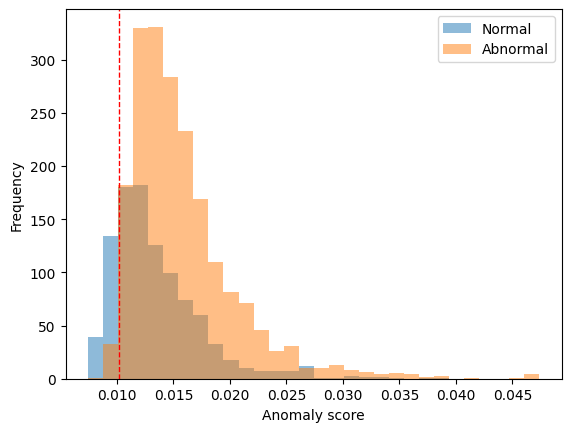

In [142]:
# Gernerating a plot
arr_label = np.array(dic_loss['label'])
arr_score = np.array(dic_loss['score'])
score_min = arr_score.min()
score_max = arr_score.max()
plt.hist(arr_score[np.where(arr_label == 1)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Normal')
plt.hist(arr_score[np.where(arr_label == 0)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Abnormal')
plt.xlabel("Anomaly score")
plt.ylabel("Frequency")
plt.axvline(threshold,0,1, color='red',linestyle='--',linewidth=1)
plt.legend(loc='upper right')
plt.savefig("plot.png")
plt.show()

In [143]:
trues = np.array(dic_loss['label'])
preds = np.array(dic_loss['normal']).astype(int)
print("Accuracy: {}".format(np.mean(trues == preds)))
print("Precision: {}".format(np.sum((trues == preds) & (preds == 1)) / np.sum(preds == 1)))
print("Recall: {}".format(np.sum((trues == preds) & (preds == 1)) / np.sum(trues == 1)))
print("F1: {}".format(2 * np.sum((trues == preds) & (preds == 1)) / (np.sum(preds == 1) + np.sum(trues == 1))))


Accuracy: 0.7146666666666667
Precision: 0.8214285714285714
Recall: 0.184
F1: 0.3006535947712418
